train_size: 1687
test_size: 421
Epoch 1/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.4548 - val_loss: 0.0134
Epoch 2/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1438 - val_loss: 0.0126
Epoch 3/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0384 - val_loss: 0.0100
Epoch 4/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0892 - val_loss: 0.0088
Epoch 5/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0329 - val_loss: 0.0094
Epoch 6/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0475 - val_loss: 0.0077
Epoch 7/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0636 - val_loss: 0.0083
Epoch 8/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0108 - val_loss: 0.0072
Epoch 9/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0300 - val_loss: 0.0071
Epoch 10/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0169 - val_loss: 0.0084
Epoch 11/15
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0396 - val_loss: 0.0069
Epoch 12/15
74/74 ━━━━━━━━━━━━━

/Users/zachholloway/anaconda3/lib/python3.10/site-packages/sklearn/base.py:420: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

Performance of LSTM Model:

  Root Mean Square Error (RMSE): 3.7683

  Mean Absolute Percentage Error (MAPE): 1.83


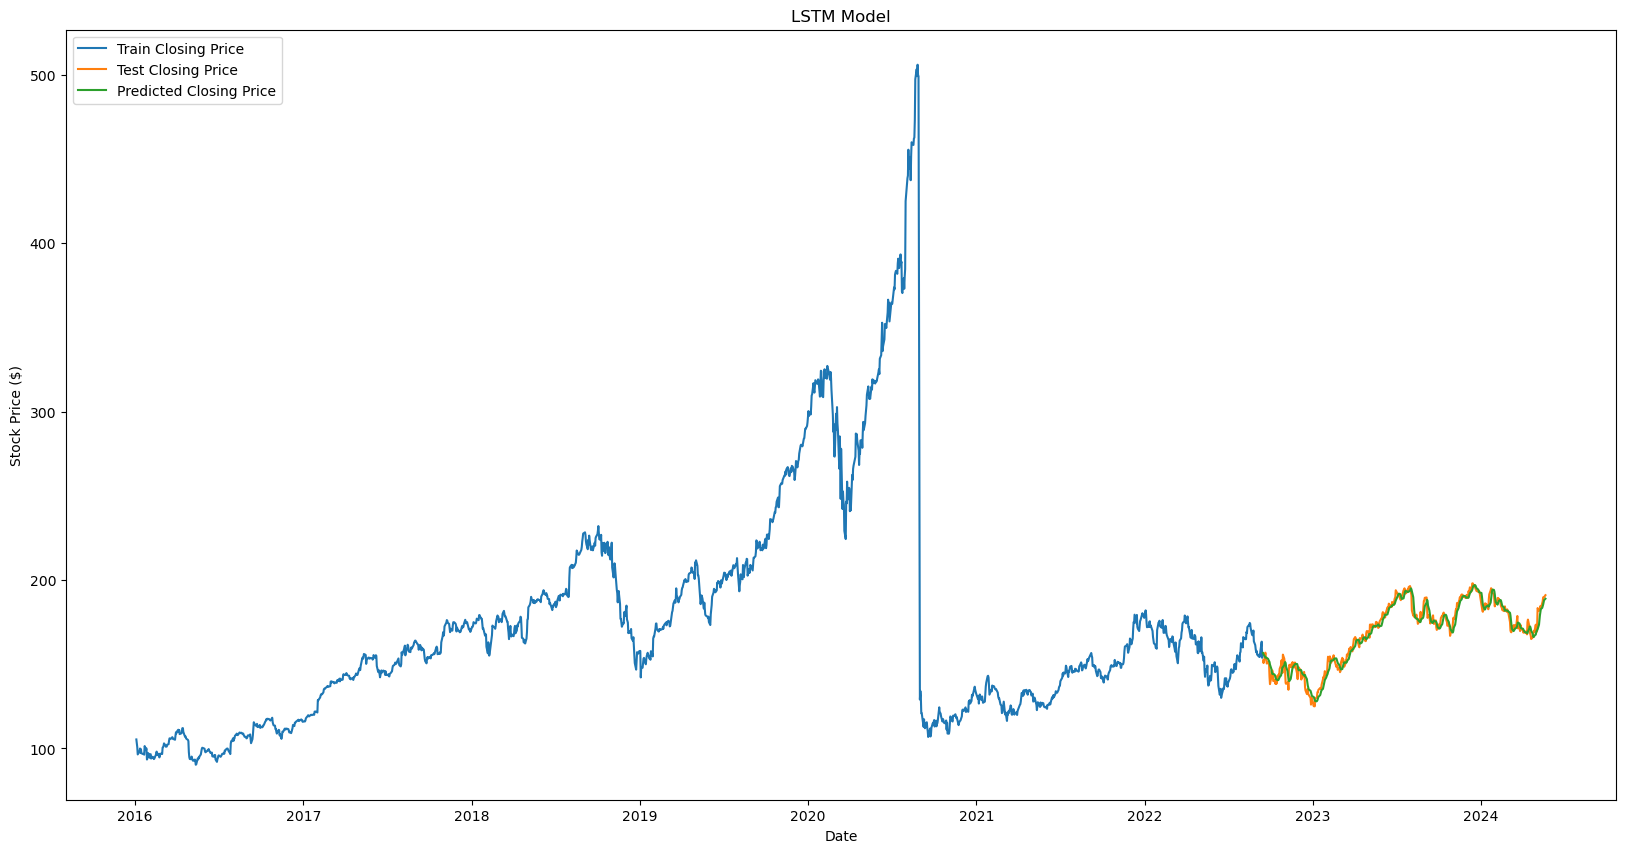

In [1]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import requests
import json
import talib
import os
import env
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.models import Model
from sklearn.preprocessing import StandardScaler

def get_previous_business_day(date):
    if date.weekday() == 0:  
        return date - timedelta(days=3)
    elif date.weekday() == 6:  
        return date - timedelta(days=2)
    else:
        return date - timedelta(days=1)

def get_years_ago_from_date(date, num_years):
    years_ago = date.replace(year=date.year - num_years)
    return get_previous_business_day(years_ago)

current_time = datetime.now()
end_date = get_previous_business_day(current_time)
start_date = get_years_ago_from_date(end_date, num_years=25)
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

symbol = "AAPL"

url = f"https://data.alpaca.markets/v2/stocks/bars?symbols={symbol}&timeframe=1Day&start={start_date_str}&end={end_date_str}&limit=10000&adjustment=raw&feed=sip&sort=asc"

headers = {
    "accept": "application/json",
    "APCA-API-KEY-ID": os.getenv("api-id"),  # Use environment variable
    "APCA-API-SECRET-KEY": os.getenv("api-secret"),  # Use environment variable
}

response = requests.get(url, headers=headers)

data = response.json()

symbol = list(data['bars'].keys())[0]
df = pd.DataFrame(data['bars'][symbol]) 

# Rename columns 
df.columns = ['Closing Price', 'High', 'Low', 'Number of Trades', 'Open', 'Date', 'Volume', 'VWAP']

# Format data (no change needed here)
df.loc[:, 'Closing Price'] = df['Closing Price'].astype(float)

df.to_csv(f"stock_market_data-{symbol}.csv", index=False)
    
# %% Train-Test split for time-series
stockprices = pd.read_csv(f"stock_market_data-{symbol}.csv", index_col="Date")

stockprices.index = pd.to_datetime(stockprices.index)

test_ratio = 0.2
training_ratio = 1 - test_ratio

train_size = int(training_ratio * len(stockprices))
test_size = int(test_ratio * len(stockprices))
print(f"train_size: {train_size}")
print(f"test_size: {test_size}")

train = stockprices[:train_size][["Closing Price"]]
test = stockprices[train_size:][["Closing Price"]]

## Split the time-series data into training seq X and output value Y
def extract_seqX_outcomeY(data, N, offset):
    X, y = [], []

    for i in range(offset, len(data)):
        X.append(data[i - N : i])
        y.append(data[i])

    return np.array(X), np.array(y)

#### Calculate the metrics RMSE and MAPE ####
def calculate_rmse(y_true, y_pred):
    rmse = np.sqrt(np.mean((y_true - y_pred) ** 2))
    return rmse

def calculate_mape(y_true, y_pred):
    y_pred, y_true = np.array(y_pred), np.array(y_true)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape
    
def plot_stock_trend(var, cur_title, stockprices=stockprices):
    ax = stockprices[["Closing Price", var, "200day"]].plot(figsize=(20, 10))
    plt.grid(False)
    plt.title(cur_title)
    plt.axis("tight")
    plt.ylabel("Stock Price ($)")

layer_units = 50
optimizer = "adam"
cur_epochs = 15
cur_batch_size = 20

cur_LSTM_args = {
    "units": layer_units,
    "optimizer": optimizer,
    "batch_size": cur_batch_size,
    "epochs": cur_epochs,
}

scaler = StandardScaler()
scaled_data = scaler.fit_transform(stockprices[["Closing Price"]])
scaled_data_train = scaled_data[: train.shape[0]]

window_size = 50
X_train, y_train = extract_seqX_outcomeY(scaled_data_train, window_size, window_size)

### Build a LSTM model and log training progress to Neptune ###

def run_LSTM(X_train, layer_units=50):
    inp = Input(shape=(X_train.shape[1], 1))

    x = LSTM(units=layer_units, return_sequences=True)(inp)
    x = LSTM(units=layer_units)(x)
    out = Dense(1, activation="linear")(x)
    model = Model(inp, out)

    # Compile the LSTM neural net
    model.compile(loss="mean_squared_error", optimizer="adam")

    return model

model = run_LSTM(X_train, layer_units=layer_units)

history = model.fit(
    X_train,
    y_train,
    epochs=cur_epochs,
    batch_size=cur_batch_size,
    verbose=1,
    validation_split=0.1,
    shuffle=True,
)
# predict stock prices using past window_size stock prices
def preprocess_testdat(data=stockprices, scaler=scaler, window_size=window_size, test=test):
    raw = data["Closing Price"][len(data) - len(test) - window_size:].values
    raw = raw.reshape(-1,1)
    raw = scaler.transform(raw)

    X_test = [raw[i-window_size:i, 0] for i in range(window_size, raw.shape[0])]
    X_test = np.array(X_test)

    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    return X_test

X_test = preprocess_testdat()

predicted_price_ = model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price_)

# Plot predicted price vs actual closing price
test["Predictions_lstm"] = predicted_price

# Evaluate performance
rmse_lstm = calculate_rmse(np.array(test["Closing Price"]), np.array(test["Predictions_lstm"]))
mape_lstm = calculate_mape(np.array(test["Closing Price"]), np.array(test["Predictions_lstm"]))

# Display the results
print(f"\nPerformance of LSTM Model:\n")
print(f"  Root Mean Square Error (RMSE): {rmse_lstm:.4f}\n")
print(f"  Mean Absolute Percentage Error (MAPE): {mape_lstm:.2f}")
      
### Plot prediction and true trends and log to Neptune
def plot_stock_trend_lstm(train, test):
    fig = plt.figure(figsize = (20,10))
    plt.plot(np.asarray(train.index), np.asarray(train["Closing Price"]), label = "Train Closing Price")
    plt.plot(np.asarray(test.index), np.asarray(test["Closing Price"]), label = "Test Closing Price")
    plt.plot(np.asarray(test.index), np.asarray(test["Predictions_lstm"]), label = "Predicted Closing Price")
    plt.title("LSTM Model")
    plt.xlabel("Date")
    plt.ylabel("Stock Price ($)")
    plt.legend(loc="upper left")

plot_stock_trend_lstm(train, test)